# In This notebook 

An autoencoder will be trained whose features are:



*   First actually architecture of  it is inspired from vgg 16
*   there will be batch normalization layers to prevent gradient vanishing problem
*   activation function in hidden layer will be relu because of same reason using batch normalization 
*   becasue of input images only have 255 or 0 values we are going to translate this problem as a binary clasification so loss function will be binary cross entropy and output activation fuction will be sigmoid
*   rule of tumb is the total number of training data points should be at least 2 or 3 times larger than number of parameters in neural networks
    *    Number of trainable parameters in our model is 308,593
    *    Because of time it takes every epoch 32 * 10000 data point will be generated 
    




In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

import cv2
import os
import random
import numpy as np
# from tqdm import tqdm

SHAPE = (224,224,1)
TRAIN_DIR = "/content/drive/My Drive/challange_data/train_data"

## Fuction for creating Model

In [3]:
#Batch Normalization is usually inserted after fully connected layers or Convolutional layers and before non-linearity
def create_model(orginal =False, input_shape = (224, 224, 1)):
    #inspired from vgg16
    if(orginal):
        input_img = Input(shape=input_shape) 

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((2, 2), padding='same')(x)#112 112 64
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((2, 2), padding='same')(x)#56 56 128

        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((2, 2), padding='same')(x)#28 28 128

        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((2, 2), padding='same')(x)#14 14 512

        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        encoded = MaxPooling2D((2, 2), padding='same', name="encoder")(x)#7 7 512
        
        x = UpSampling2D((2, 2))(encoded)#14 14 512
        
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)#28 28 512

        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)#56 56 512

        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)#112 112 256

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)#224 224 128

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        return Model(input_img, decoded)
    input_img = Input(shape=input_shape) 

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)#112 112 16
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)#56 56 32

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D((2, 2), padding='same')(x)#28 28 32
    #-------
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)#14 14 64

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    encoded = MaxPooling2D((2, 2), padding='same', name="encoder")(x)#7 7 64
    
    x = UpSampling2D((2, 2))(encoded)#14 14 64
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)#28 28 64

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    #-------
    x = UpSampling2D((2, 2))(x)#56 56 64

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)#112 112 64

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)#224 224 32

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

In [11]:
def pepper(image):
    amount = 0.2
    out = image.copy()

    # Pepper mode
    num_pepper = np.ceil(amount* image.size )
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

In [12]:
def flip(image):
    if(random.randint(0,1) == 1):
        return cv2.flip(image,1) 
    return image

In [13]:
def rotate(image):
    prob = random.randint(0,3)
    if(prob == 0):
        return cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif(prob == 1):
        return cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    elif(prob == 2):
        return cv2.rotate(image,cv2.ROTATE_180)
    return image

In [14]:
def data_generator(directory, batch_size):

    i = 0
    file_list = os.listdir(directory)
    random.shuffle(file_list)
    while True:
        train_x = []
        train_y = []
        for _ in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            
            image = cv2.resize(cv2.imread("{}/{}".format(directory,sample),0), (SHAPE[0], SHAPE[1]), interpolation=cv2.INTER_NEAREST) # INTER_NEAREST to protect binary structure
    
            image = flip(image)
            image = rotate(image)
            image = image.astype(float)/255.
            #if random.randint(0,1)<1:
            #    image = pepper(image)
            train_x.append(pepper(image))
            train_y.append(image)

        train_x = np.array(train_x)
        train_y = np.array(train_y)
        #print("---------------------------")
        yield train_x.reshape((-1, SHAPE[0], SHAPE[1], 1)), train_y.reshape((-1, SHAPE[0], SHAPE[1], 1))
        #yield train_y.reshape((-1, SHAPE[0], SHAPE[1], 1))

# Generated Data Example

In [15]:
a = data_generator(TRAIN_DIR, 1)
for _ in range(5):
    x, y = next(a)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x[0].reshape((224,224)),cmap="gray")
    ax2.imshow(y[0].reshape((224,224)),cmap="gray")

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '/content/drive/My Drive/challange_data/train_data'

In [16]:
def compile_model(model):
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.99, nesterov=True)
    # model.compile(optimizer='nadam', loss=custom_loss)
    model.compile(optimizer=sgd, loss="binary_crossentropy")
    return model

In [17]:
def train_with_generator_model(model, directory):

    model = compile_model(model)
    
    checkpoint = ModelCheckpoint("/content/drive/My Drive/challange_data/bin_v{epoch:02d}.hdf5", verbose=1) #val_acc yok ondan val_loss
    
    """
    fit_generator(object, generator, steps_per_epoch, epochs = 1,
        verbose = getOption("keras.fit_verbose", default = 1),
        callbacks = NULL, view_metrics = getOption("keras.view_metrics",
        default = "auto"), validation_data = NULL, validation_steps = NULL,
        class_weight = NULL, max_queue_size = 10, workers = 1,
        initial_epoch = 0)
    """
    
    model.fit_generator(data_generator(directory, 32),
                        steps_per_epoch = 10000,
                        epochs = 10,
                        validation_data=data_generator(directory, 100),
                        validation_steps = 5,
                        callbacks=[TensorBoard(log_dir='/content/drive/My Drive/challange_data', histogram_freq=0, write_graph=False), checkpoint ],
                        verbose=1)
    model.save("/content/drive/My Drive/challange_data/binary.hdf5")

In [18]:
def train_model(model, batch_size = 50, dataset_size = 1000):

    model = compile_model(model)
    
    checkpoint = ModelCheckpoint("/content/drive/My Drive/challange_data/bin_v{epoch:02d}.hdf5", verbose=1) #val_acc yok ondan val_loss
    
    a = data_generator("/content/drive/My Drive/challange_data/train_data", dataset_size)
    
    x = next(a)
    print(x.shape)
    #print(y.shape)
    print("batch_size: ",batch_size)
    model.fit(x, x,
                        epochs=10,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split = 0.1,
                        callbacks=[TensorBoard(log_dir='/content/drive/My Drive/challange_data', histogram_freq=0, write_graph=False), checkpoint ])
    model.save("/content/drive/My Drive/challange_data/binary.hdf5")

In [19]:
def retrain_(model_dir, dataset_dir, batch_size = 50,  dataset_size = 1000):
    model = load_model(model_dir)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint("/content/drive/My Drive/challange_data/bin_v{epoch:02d}.hdf5", monitor='vall_acc', verbose=1) #val_acc yok ondan val_loss
    
    a = data_generator("/content/drive/My Drive/challange_data/train_data", dataset_size)
    
    x, y = next(a)
    print(x.shape)
    print(y.shape)
    print("batch_size: ",batch_size)
    model.fit(x, y,
                        epochs=10,
                        batch_size=100,
                        shuffle=True,
                        validation_split = 0.1,
                        callbacks=[checkpoint])
    model.save("/content/drive/My Drive/challange_data/binary.hdf5")
    return model

In [20]:
autoencoder = create_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0     

In [21]:
train_with_generator_model(autoencoder,TRAIN_DIR)


C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-17-8c4124ef3462>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_generator(directory, 32),


FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '/content/drive/My Drive/challange_data/train_data'

In [22]:
def retrain(path_to_model, directory, epoch = 5):

    model = load_model(path_to_model)
    compile_model(model)

    checkpoint = ModelCheckpoint("/content/drive/My Drive/challange_data/re_bin_v{epoch:02d}.hdf5", verbose=1) #val_acc yok ondan val_loss

    
    model.fit_generator(data_generator(directory, 32),
                        steps_per_epoch = 10000,
                        epochs = epoch,
                        validation_data=data_generator(directory, 100),
                        validation_steps = 5,
                        callbacks=[checkpoint],
                        verbose=1)
    model.save("/content/drive/My Drive/challange_data/re_binary.hdf5")
    return model

Because train phase interupted, train of model will be contuinied from last checkpoint which is bin_v07.hdf5

In [ ]:
path_to_model = "/content/drive/My Drive/challange_data/bin_v07.hdf5"
re_auto = retrain(path_to_model, TRAIN_DIR) 

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


10000/10000 [==============================] - 2124s 212ms/step - loss: 0.0793 - val_loss: 0.0803

Epoch 00001: saving model to /content/drive/My Drive/challange_data/re_bin_v01.hdf5
Epoch 2/5
10000/10000 [==============================] - 1992s 199ms/step - loss: 0.0774 - val_loss: 0.0711

Epoch 00002: saving model to /content/drive/My Drive/challange_data/re_bin_v02.hdf5
Epoch 3/5
10000/10000 [==============================] - 1976s 198ms/step - loss: 0.0758 - val_loss: 0.0720

Epoch 00003: saving model to /content/drive/My Drive/challange_data/re_bin_v03.hdf5
Epoch 4/5
10000/10000 [==============================] - 1985s 199ms/step - loss: 0.0743 - val_loss: 0.0733

Epoch 00004: saving model to /content/drive/My Drive/challange_data/re_bin_v04.hdf5
Epoch 5/5
10000/10000 [==============================] - 1982s 198ms/step - loss: 0.0730 - val_loss: 0.0684

Epoch 00005: saving model to /content/drive/My Drive/challange_data/re_bin_v05.hdf5


In [ ]:
re_auto = load_model("/content/drive/My Drive/challange_data/re_bin_v05.hdf5")

In [ ]:
def sample_output_generate(model, num_of_sample = 5, directory="/content/drive/My Drive/challange_data/test_data"):
    dir_list = os.listdir(directory)
    for i in range(1,2*num_of_sample+1,2):
        file_name = dir_list[random.randint(0,len(dir_list))]
        image = cv2.resize(cv2.imread("{}/{}".format(directory, file_name),0), (SHAPE[0], SHAPE[1]), interpolation=cv2.INTER_NEAREST)
        
        copy = image.copy()

        image = image.astype(float)/255.
        res = re_auto.predict(image.reshape((1, 224,224,1)))
        res = res.reshape((224, 224))*255
        res = np.array(res, dtype=np.uint8)
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(copy,cmap="gray")
        ax2.imshow(res,cmap="gray")


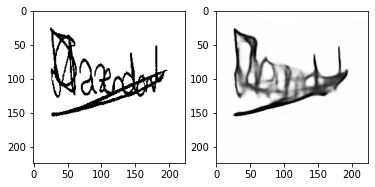

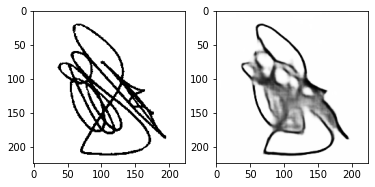

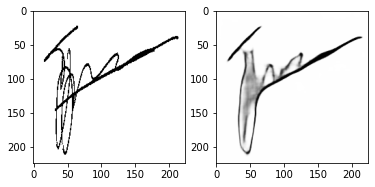

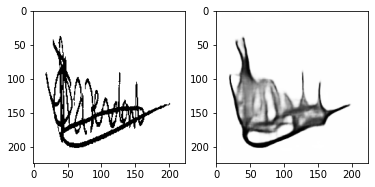

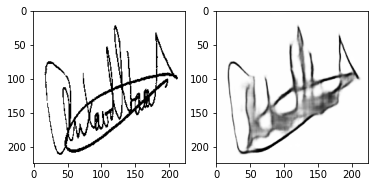

In [ ]:
sample_output_generate(re_auto)

In [4]:
model = create_model(input_shape = (224, 224, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0     

In [5]:
model.compile(optimizer='sgd', loss='mean_squared_error')


In [6]:
def get_images(directory):
    images = []
    for image_file in os.listdir(directory): 
        image = cv2.imread(directory+image_file)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)            
        images.append(image)
    return np.array(images)

In [7]:
data = get_images('resized_merged_images/')
data.shape

(864, 224, 224, 3)

In [10]:
X_train, X_test = data[:650], data[650:]

In [11]:
model.fit(X_train, X_train, epochs=30, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/30
21/21 [==============================] - 205s 10s/step - loss: 0.2653 - val_loss: 0.1931
Epoch 2/30
21/21 [==============================] - 200s 10s/step - loss: 0.2299 - val_loss: 0.1409
Epoch 3/30
21/21 [==============================] - 197s 9s/step - loss: 0.2059 - val_loss: 0.1049
Epoch 4/30
21/21 [==============================] - 206s 10s/step - loss: 0.1808 - val_loss: 0.0814
Epoch 5/30
21/21 [==============================] - 203s 10s/step - loss: 0.1625 - val_loss: 0.0667
Epoch 6/30
21/21 [==============================] - 200s 10s/step - loss: 0.1435 - val_loss: 0.0579
Epoch 7/30
21/21 [==============================] - 203s 10s/step - loss: 0.1306 - val_loss: 0.0533
Epoch 8/30
21/21 [==============================] - 203s 10s/step - loss: 0.1181 - val_loss: 0.0507
Epoch 9/30
21/21 [==============================] - 200s 10s/step - loss: 0.1107 - val_loss: 0.0493
Epoch 10/30
21/21 [==============================] - 202s 10s/step - loss: 0.1002 - val_loss: 0.0492


In [12]:
pred = model.predict(X_test[0:2])
pred.shape

(2, 224, 224, 1)

In [13]:
model.save('modelss')

INFO:tensorflow:Assets written to: modelss\assets


In [14]:
X_test = cv2.cvtColor(X_test[0], cv2.COLOR_BGR2GRAY)

In [15]:
pred = pred[0]

In [16]:
pred.shape

(224, 224, 1)

In [17]:
X_test = np.reshape(X_test, (224, 224, 1))
X_test.shape

(224, 224, 1)

In [18]:
X_train.shape

(650, 224, 224, 3)

In [19]:
cv2.imshow('d', X_train[0])
cv2.waitKey(0)
cv2.destroyWindow()

TypeError: destroyWindow() missing required argument 'winname' (pos 1)

In [1]:
cv2.imshow('d', pred)
cv2.waitKey(0)
cv2.destroyWindow()

NameError: name 'cv2' is not defined

In [20]:
cv2.imwrite('sample.tiff', X_test)

True

In [22]:
image = cv2.imread('your_file3.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (224, 224))
cv2.imshow('d', image)
cv2.waitKey(0)
cv2.destroyWindow()

TypeError: destroyWindow() missing required argument 'winname' (pos 1)

In [25]:
# pred = model.predict(image)
image = np.reshape(image, (1,224,224,3))
pred = model.predict(image)

In [26]:
cv2.imshow('d', pred[0])
cv2.waitKey(0)
cv2.destroyWindow()

TypeError: destroyWindow() missing required argument 'winname' (pos 1)